# Import Libraries and Data

In [148]:
import pandas as pd
import numpy as np
from math import sqrt

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
sns.set(style='darkgrid')

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, plot_confusion_matrix

import pickle

In [149]:
games = pd.read_csv('./Data/games.csv')
players = pd.read_csv('./Data/players.csv')
plays = pd.read_csv('./Data/plays.csv')
pff = pd.read_csv('./Data/PFFScoutingData.csv')
tracking_2018 = pd.read_csv('./Data/tracking2018.csv')
tracking_2019 = pd.read_csv('./Data/tracking2019.csv')
tracking_2020 = pd.read_csv('./Data/tracking2020.csv')

## Data Setup

### Concatenate Tracking Data and Orient all Kicks to the Right

In [150]:
# Concatenate tracking data
tracking_full = pd.concat([tracking_2018, tracking_2019, tracking_2020], axis=0)
tracking_full.reset_index(drop=True, inplace=True)

# Flip so all plays go begin with kick to the right
tracking_full.loc[tracking_full['playDirection'] == "left", 'x'] = 120-tracking_full.loc[tracking_full['playDirection'] == "left", 'x']
tracking_full.loc[tracking_full['playDirection'] == "left", 'y'] = 160/3-tracking_full.loc[tracking_full['playDirection'] == "left", 'y']

# Punt Coverage and Return Analysis

### Filter Plays and PFF Data to Punt Plays

In [151]:
# Filter for punts only
punt_plays = plays[plays['specialTeamsPlayType'] == 'Punt'].copy()

# Add column for yards from endzone
punt_plays['yardsFromEndzone'] = np.where(punt_plays['possessionTeam'] == punt_plays['yardlineSide'],
                                          100 - punt_plays['yardlineNumber'],
                                          punt_plays['yardlineNumber']
                                         )

# Add bucket column for yards from endzone
conditions = [punt_plays['yardsFromEndzone'].le(50), 
              punt_plays['yardsFromEndzone'].gt(50) & punt_plays['yardsFromEndzone'].le(65),
              punt_plays['yardsFromEndzone'].gt(65) & punt_plays['yardsFromEndzone'].le(93),
              punt_plays['yardsFromEndzone'].gt(93)
             ]

choices = ['0-50', '50-65', '65-93', '93+']

punt_plays['yardsFromEndzoneBucket'] = np.select(conditions, choices)

In [152]:
# Filter PFF data for punt plays
pff_punt_plays = pff[pff['kickType'].isin(['N', 'R', 'A'])]

### Filter Tracking Data to Punt Plays

In [153]:
# Only keep plays considered punt plays by PFF
punt_tracking = tracking_full.merge(pff_punt_plays[['gameId', 'playId']],
                                    on=['gameId', 'playId'],
                                    how='inner'
                                   ).reset_index(drop=True)

### Prepare Tracking Data for Point in Time Metrics

In [154]:
# Merge player info to punt tracking data
play_cols = ['gameId', 'playId', 'kickerId', 'returnerId', 'possessionTeam', 'absoluteYardlineNumber']
pff_cols = ['gameId', 'playId', 'gunners', 'vises']
games_cols = ['gameId', 'homeTeamAbbr', 'visitorTeamAbbr']

punt_tracking = punt_tracking.merge(plays[play_cols], on=['gameId', 'playId'])\
                                        .merge(pff[pff_cols], on=['gameId', 'playId'])\
                                        .merge(games[games_cols], on='gameId')

In [155]:
# Convert merged ID columns to integer
punt_tracking['kickerId'].fillna(0, inplace=True)
punt_tracking['kickerId'] = punt_tracking['kickerId'].astype(int)
punt_tracking['returnerId'] = punt_tracking['returnerId'].str.split(';').str[0]
punt_tracking.dropna(subset = ['returnerId'], inplace=True)
punt_tracking['returnerId'] = punt_tracking['returnerId'].astype(int)

In [156]:
# Flip the yardline number for plays going left
punt_tracking['absoluteYardlineNumber'] = np.where(punt_tracking['playDirection']=='left', 
                                                         (punt_tracking['absoluteYardlineNumber'] - 120) * -1,
                                                         punt_tracking['absoluteYardlineNumber']
                                                        )

# Adjust x to be relative to line of scrimmage
punt_tracking['x_adj'] = punt_tracking['x'] - punt_tracking['absoluteYardlineNumber']

In [157]:
# Create team name, team and number combination, and kicking team True/False columns
punt_tracking['jerseyNumber'].fillna(0, inplace=True)
punt_tracking['teamName'] = np.where(punt_tracking['team']=='football', 'football',
                                     np.where(punt_tracking['team']=='home', 
                                              punt_tracking['homeTeamAbbr'],
                                              punt_tracking['visitorTeamAbbr']
                                             )
                                    )

punt_tracking['teamNumber'] = punt_tracking['teamName'] + ' ' + punt_tracking['jerseyNumber'].astype(int).astype(str)

punt_tracking['kickingTeam'] = punt_tracking['teamName']==punt_tracking['possessionTeam']

In [158]:
# Create True/False gunner and vise columns to mark gunners and vises
punt_tracking['gunner_y_n'] = punt_tracking.apply(lambda row: row['teamNumber'] in str(row['gunners']), axis=1)
punt_tracking['vise_y_n'] = punt_tracking.apply(lambda row: row['teamNumber'] in str(row['vises']), axis=1)

In [159]:
# Create role player column to track punter/return/gunner/vise/football
punt_tracking['rolePlayer'] = np.where(punt_tracking['nflId']==punt_tracking['kickerId'], 'punter',
                                             np.where(punt_tracking['nflId']==punt_tracking['returnerId'], 'returner',
                                                      np.where(punt_tracking['gunner_y_n'], 'gunner',
                                                               np.where(punt_tracking['vise_y_n'], 'vise',
                                                                        np.where(punt_tracking['team']=='football', 'football', 'other'
                                                                                )
                                                                       )
                                                              )
                                                     )
                                            )

In [160]:
# Determine snap frame and create new frame column relative to the snap
punt_snaps = punt_tracking[punt_tracking['event']=='ball_snap'][['gameId', 'playId', 'frameId', 'event']].drop_duplicates()
punt_snaps.rename(columns={'frameId' : 'snap'}, inplace=True)

punt_tracking = punt_tracking.merge(punt_snaps[['gameId', 'playId', 'snap']], on=['gameId', 'playId'])
punt_tracking['frameVsSnap'] = punt_tracking['frameId'] - punt_tracking['snap']

## Calculate Point in Time Metrics for Each Frame

#### Team Penetration by Frame

In [161]:
# Calculate average team position and kicking team penetration by frame
exclude = ['punter', 'returner', 'football']
group_cols = ['gameId', 'playId', 'frameVsSnap', 'teamName']

penetration_by_frame_kicking = punt_tracking[(~punt_tracking['rolePlayer'].isin(exclude)) &
                                                   (punt_tracking['kickingTeam'])
                                                  ].groupby(group_cols)['x_adj'].mean().reset_index()

penetration_by_frame_receiving = punt_tracking[(~punt_tracking['rolePlayer'].isin(exclude)) &
                                                     (~punt_tracking['kickingTeam'])
                                                    ].groupby(group_cols)['x_adj'].mean().reset_index()


team_penetration_by_frame = penetration_by_frame_kicking.merge(penetration_by_frame_receiving, on=['gameId', 'playId', 'frameVsSnap'])
team_penetration_by_frame.columns = ['gameId', 'playId', 'frameVsSnap', 'kickTeam', 'kickTeamPosition', 'recTeam', 'recTeamPosition']
team_penetration_by_frame['kickTeamPenetration'] = team_penetration_by_frame['kickTeamPosition'] - team_penetration_by_frame['recTeamPosition']

#### Gunner Penetration by Frame

In [162]:
# Calculate average gunner and vise position and average gunner penetration by frame
include = ['gunner', 'vise']

penetration_by_frame_gunner = punt_tracking[(punt_tracking['rolePlayer'].isin(include)) &
                                                  (punt_tracking['kickingTeam'])
                                                 ].groupby(group_cols)['x_adj'].mean().reset_index()

penetration_by_frame_vise = punt_tracking[(punt_tracking['rolePlayer'].isin(include)) &
                                                (~punt_tracking['kickingTeam'])
                                               ].groupby(group_cols)['x_adj'].mean().reset_index()

gunner_penetration_by_frame = penetration_by_frame_gunner.merge(penetration_by_frame_vise, on=['gameId', 'playId', 'frameVsSnap'])
gunner_penetration_by_frame.columns = ['gameId', 'playId', 'frameVsSnap', 'kickTeam', 'gunnerPosition', 'recTeam', 'visePosition']
gunner_penetration_by_frame['gunnerPenetration'] = gunner_penetration_by_frame['gunnerPosition'] - gunner_penetration_by_frame['visePosition']

#### Vertical Spread and Deviation of Gaps by Frame

In [163]:
# Calculate vertical spread of the punt team
kick_team_spread = punt_tracking[(punt_tracking['kickingTeam'])
                                      ].groupby(group_cols)['y'].agg({np.min,np.max}).reset_index()

kick_team_spread['max_spread'] = kick_team_spread['amax'] - kick_team_spread['amin']

In [164]:
# Calculate standard deviation of the player gaps
kick_team_gaps = punt_tracking[punt_tracking['kickingTeam']].sort_values(['gameId', 'playId', 'frameVsSnap', 'y']).copy()

kick_team_gaps['y_gap'] = kick_team_gaps['y'].diff()

mask = ((kick_team_gaps['gameId']==kick_team_gaps['gameId'].shift(1)) &
        (kick_team_gaps['playId']==kick_team_gaps['playId'].shift(1)) &
        (kick_team_gaps['frameVsSnap']==kick_team_gaps['frameVsSnap'].shift(1))
       )

kick_team_gaps['y_gap'] = np.where(mask!=True, np.nan, kick_team_gaps['y_gap'])

kick_team_gaps = kick_team_gaps.groupby(['gameId', 'playId', 'frameVsSnap'])['y_gap'].std().reset_index()
kick_team_gaps.columns = ['gameId', 'playId', 'frameVsSnap', 'gapStdDev']

In [165]:
# Merge gap deviation to spread dataframe
kick_team_spread = kick_team_spread.merge(kick_team_gaps, on=['gameId', 'playId', 'frameVsSnap'])

#### Nearest Defender to Returner by Frame

In [166]:
# Calculate the distance between each defender and the returner, as well as average and minimum by frame
returner_position = punt_tracking[punt_tracking['rolePlayer']=='returner'][['gameId', 'playId', 'frameVsSnap', 'x', 'y']]
returner_position.columns = ['gameId', 'playId', 'frameVsSnap', 'x_returner', 'y_returner']

punt_tracking = punt_tracking.merge(returner_position, on=['gameId', 'playId', 'frameVsSnap'])

punt_tracking['dist_to_returner'] = np.sqrt((punt_tracking['x_returner'] - punt_tracking['x'])**2 + (punt_tracking['y_returner'] - punt_tracking['y'])**2)

dist_to_returner = punt_tracking[(~punt_tracking['rolePlayer'].isin(exclude)) &
                                 (punt_tracking['kickingTeam'])
                                ].groupby(['gameId', 'playId', 'frameVsSnap'])['dist_to_returner'].agg({np.min,np.mean}).reset_index()

dist_to_returner.columns = ['gameId', 'playId', 'frameVsSnap', 'minDist', 'meanDist']

### Combine Punt Details Into a Single Dataframe

In [167]:
def merge_frame_data(df1, df2, on_cols, merge_cols, frame=[], rename_cols=[]):
    """
    Merge tracking data for specified frame(s) from specified df.
    """
    for f in frame:
        df1 = df1.merge(df2[df2['frameVsSnap']==f][merge_cols], on=on_cols)
        if rename_cols:
            for col in rename_cols:
                df1.rename(columns={col : col + '_frame' + str(f)}, inplace=True)

    return df1

In [168]:
# Merge relevant columns from plays and pff dataframes
pff_filtered = pff_punt_plays[['gameId', 'playId', 'snapDetail', 'operationTime', 'hangTime', 'kickDirectionActual']]
punt_plays_filtered = punt_plays[['gameId', 'playId', 'specialTeamsResult', 'penaltyCodes', 'kickLength', 
                                  'kickReturnYardage', 'playResult', 'yardsFromEndzoneBucket']]

punt_data_combined = pff_filtered.merge(punt_plays_filtered, on=['gameId', 'playId'], how='inner')

In [169]:
# Merge team penetration data
on_cols = ['gameId', 'playId']
merge_cols = on_cols + ['kickTeam', 'recTeam', 'kickTeamPosition', 'recTeamPosition']
rename_cols = ['kickTeamPosition', 'recTeamPosition']

punt_data_combined = merge_frame_data(punt_data_combined,
                                      team_penetration_by_frame,
                                      on_cols=on_cols,
                                      merge_cols=merge_cols,
                                      frame=[30],
                                      rename_cols=rename_cols
                                     )

merge_cols = on_cols + rename_cols

punt_data_combined = merge_frame_data(punt_data_combined,
                                      team_penetration_by_frame,
                                      on_cols=on_cols,
                                      merge_cols=merge_cols,
                                      frame=[40, 50],
                                      rename_cols=rename_cols
                                     )

In [170]:
# Merge gunner penetration data
rename_cols = ['gunnerPenetration']
merge_cols = on_cols + rename_cols

punt_data_combined = merge_frame_data(punt_data_combined,
                                      gunner_penetration_by_frame,
                                      on_cols=on_cols,
                                      merge_cols=merge_cols,
                                      frame=[30, 40, 50],
                                      rename_cols=rename_cols
                                     )

In [171]:
# Merge kick team spread and gap data
rename_cols = ['max_spread', 'gapStdDev']
merge_cols = on_cols + rename_cols

punt_data_combined = merge_frame_data(punt_data_combined,
                                      kick_team_spread,
                                      on_cols=on_cols,
                                      merge_cols=merge_cols,
                                      frame=[30, 40, 50],
                                      rename_cols=rename_cols
                                     )

In [172]:
# Merge defender distance data
rename_cols = ['minDist', 'meanDist']
merge_cols = on_cols + rename_cols

punt_data_combined = merge_frame_data(punt_data_combined,
                                      dist_to_returner,
                                      on_cols=on_cols,
                                      merge_cols=merge_cols,
                                      frame=[30, 40, 50],
                                      rename_cols=rename_cols
                                     )

In [173]:
# Reorder the columns in the final dataframe
new_order = ['gameId',
             'playId',
             'kickTeam',
             'recTeam',
             'snapDetail',
             'kickDirectionActual',
             'specialTeamsResult',
             'penaltyCodes',
             'yardsFromEndzoneBucket',
             'kickLength',
             'kickReturnYardage',
             'playResult',
             'operationTime',
             'hangTime',
             'kickTeamPosition_frame30',
             'kickTeamPosition_frame40',
             'kickTeamPosition_frame50',
             'recTeamPosition_frame30',
             'recTeamPosition_frame40',
             'recTeamPosition_frame50',
             'gunnerPenetration_frame30',
             'gunnerPenetration_frame40',
             'gunnerPenetration_frame50',
             'max_spread_frame30',
             'max_spread_frame40',
             'max_spread_frame50',
             'gapStdDev_frame30',
             'gapStdDev_frame40',
             'gapStdDev_frame50',
             'minDist_frame30',
             'minDist_frame40',
             'minDist_frame50',
             'meanDist_frame30',
             'meanDist_frame40',
             'meanDist_frame50']

punt_data_combined = punt_data_combined[new_order]

## Explore Correlation and Collinearity

In [174]:
# Change NaN to zero for kickReturnYardage
punt_data_combined['kickReturnYardage'].fillna(0, inplace=True)

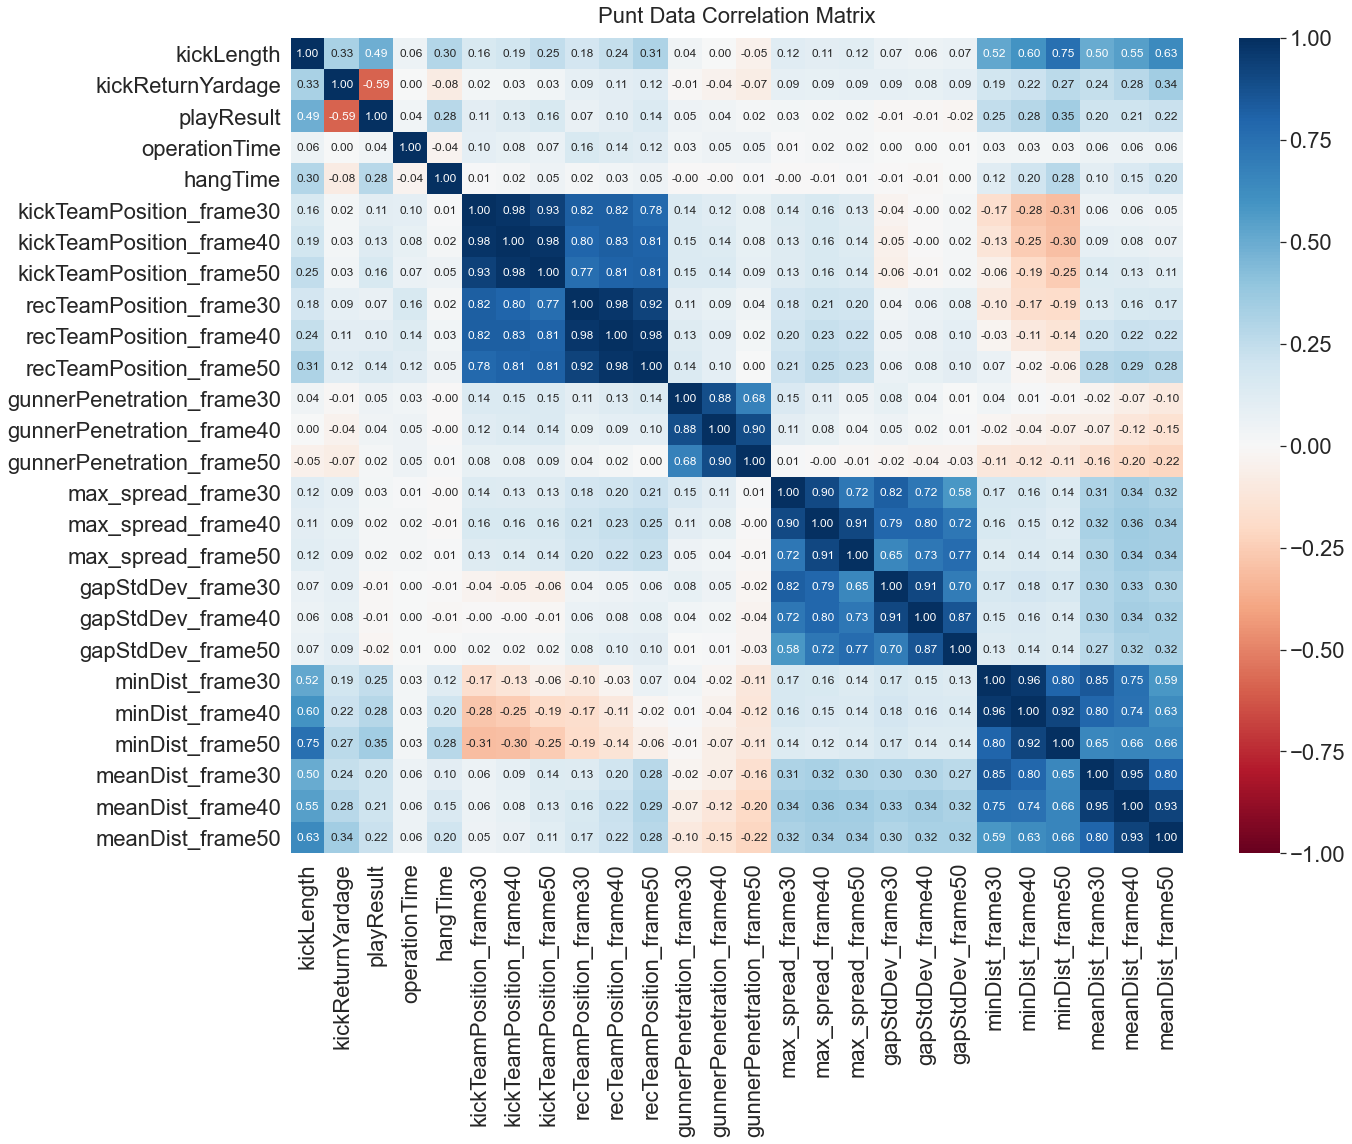

In [246]:
# Display correlation matrix
corr = punt_data_combined[new_order[9:]].corr()

plt.figure(figsize=[20,15])
ax = plt.axes()
plt.rcParams.update({'font.size': 12})
ax.set_title('Punt Data Correlation Matrix', fontsize=22, pad=15)
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdBu', annot=True, fmt='.2f', vmin=-1.0)
plt.show();

In [176]:
# Drop output variables to perform for VIF calculation
output_var = ['kickReturnYardage', 'playResult']
linear_reg_vif = punt_data_combined[new_order[12:]].dropna()

# Create constant and run VIF calculation
X = sm.tools.add_constant(linear_reg_vif)
vif = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)
display(vif)

const                        778.993210
operationTime                  1.064924
hangTime                       1.204392
kickTeamPosition_frame30      87.209482
kickTeamPosition_frame40     413.899915
kickTeamPosition_frame50     155.390778
recTeamPosition_frame30      129.042941
recTeamPosition_frame40      626.585792
recTeamPosition_frame50      227.595010
gunnerPenetration_frame30      7.519828
gunnerPenetration_frame40     22.480009
gunnerPenetration_frame50      9.816591
max_spread_frame30            10.247222
max_spread_frame40            24.398503
max_spread_frame50            10.492938
gapStdDev_frame30             11.812408
gapStdDev_frame40             15.918561
gapStdDev_frame50              6.268163
minDist_frame30               84.592575
minDist_frame40              159.147647
minDist_frame50               29.772727
meanDist_frame30              50.825298
meanDist_frame40              92.219065
meanDist_frame50              24.728692
dtype: float64

In [177]:
# New run of VIF, using frame 30 only
linear_reg_vif = punt_data_combined[['operationTime', 'hangTime', 'kickTeamPosition_frame30', 'recTeamPosition_frame30',
                                    'gunnerPenetration_frame30', 'max_spread_frame30', 'gapStdDev_frame30', 'minDist_frame30',
                                    'meanDist_frame30']].dropna()

X = sm.tools.add_constant(linear_reg_vif)
vif = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)
display(vif)

const                        592.698451
operationTime                  1.033749
hangTime                       1.019699
kickTeamPosition_frame30       3.387015
recTeamPosition_frame30        3.266477
gunnerPenetration_frame30      1.098679
max_spread_frame30             3.477290
gapStdDev_frame30              3.419473
minDist_frame30                4.817486
meanDist_frame30               5.059358
dtype: float64

In [178]:
# New run of VIF, frame 40 only
linear_reg_vif = punt_data_combined[['operationTime', 'hangTime', 'kickTeamPosition_frame40', 'recTeamPosition_frame40',
                                    'gunnerPenetration_frame40', 'max_spread_frame40', 'gapStdDev_frame40', 'minDist_frame40',
                                    'meanDist_frame40']].dropna()

X = sm.tools.add_constant(linear_reg_vif)
vif = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)
display(vif)

const                        588.792974
operationTime                  1.028355
hangTime                       1.052605
kickTeamPosition_frame40       3.619724
recTeamPosition_frame40        3.467088
gunnerPenetration_frame40      1.088129
max_spread_frame40             3.042988
gapStdDev_frame40              2.949684
minDist_frame40                3.176581
meanDist_frame40               3.411552
dtype: float64

In [179]:
# New run of VIF, frame 50 only
linear_reg_vif = punt_data_combined[['operationTime', 'hangTime', 'kickTeamPosition_frame50', 'recTeamPosition_frame50',
                                    'gunnerPenetration_frame50', 'max_spread_frame50', 'gapStdDev_frame50', 'minDist_frame50',
                                    'meanDist_frame50']].dropna()

X = sm.tools.add_constant(linear_reg_vif)
vif = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)
display(vif)

const                        575.722670
operationTime                  1.026425
hangTime                       1.113748
kickTeamPosition_frame50       3.516114
recTeamPosition_frame50        3.405076
gunnerPenetration_frame50      1.087727
max_spread_frame50             2.653133
gapStdDev_frame50              2.580701
minDist_frame50                2.384822
meanDist_frame50               2.525262
dtype: float64

## Run Linear Regression

In [180]:
# Set feature and target columns and create separate dataframes (drop NA)
x_cols = ['kickLength', 'operationTime', 'hangTime', 'kickTeamPosition_frame40', 'recTeamPosition_frame40',
          'gunnerPenetration_frame40', 'max_spread_frame40', 'gapStdDev_frame40', 'minDist_frame40',
          'meanDist_frame40']

y_cols = ['kickReturnYardage']

punt_reg_data = punt_data_combined[x_cols + y_cols].dropna()

X = punt_reg_data[x_cols]
Y = punt_reg_data[y_cols]

In [181]:
# Train test split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=1)

In [182]:
# Initialize, train, and score Random Forest Regressor
rf_regressor = RandomForestRegressor(random_state=13)
rf_regressor.fit(x_train, y_train)

score = rf_regressor.score(x_test, y_test)

print('Random Forest Regressor R-Squared:  ' + str(format(score, '.4f')))

<ipython-input-182-344ff6391918>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_regressor.fit(x_train, y_train)


Random Forest Regressor R-Squared:  0.0614


In [183]:
# Perform grid search for optimal Random Forest Regressor parameters
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_regressor = RandomForestRegressor(random_state=13)
rf_random = RandomizedSearchCV(estimator=rf_regressor,
                               param_distributions=random_grid,
                               n_iter=100,
                               cv=3,
                               verbose=2,
                               random_state=13,
                               n_jobs = -1)

In [184]:
# Train and score best estimator
rf_random.fit(x_train, y_train)
rf_random.best_params_
rf_random_score = rf_random.best_estimator_.score(x_test, y_test)

print('Random Forest Regressor R-Squared:  ' + str(format(rf_random_score, '.4f')))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.8min finished
/Users/davidwismer/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Random Forest Regressor R-Squared:  0.1254


In [185]:
# Display feature importances for best scoring estimator
best_rf_regressor = rf_random.best_estimator_
pd.Series(best_rf_regressor.feature_importances_, index=x_train.columns).sort_values(ascending=False)

kickLength                   0.206021
meanDist_frame40             0.148711
hangTime                     0.122881
minDist_frame40              0.099447
max_spread_frame40           0.085105
gapStdDev_frame40            0.084602
gunnerPenetration_frame40    0.076870
recTeamPosition_frame40      0.068820
kickTeamPosition_frame40     0.059461
operationTime                0.048083
dtype: float64

## Classification Model

In [186]:
def sequential_backward(model_data, target, classifier):
    """
    Accept a classification model and the full train/test data. Remove features one by one
    by determining the feature whose removal results in the highest accuracy score. Return
    a list of features in order of removal and a dataframe with all feature combinations
    and their accuracy scores, sorted by highest accuracy.
    """
    test_columns = list(model_data.columns)
    test_columns.remove(target)
    
    feature_combos = pd.DataFrame()

    backward_order = []

    while test_columns:
        cols = test_columns + [target]
        data = model_data[cols]

        X = data.drop(columns=target)
        Y = data[target]
        
        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=13)

        classifier.fit(x_train, y_train)
        y_pred = classifier.predict(x_test)
        score = accuracy_score(y_test, y_pred, normalize = True)

        test_instance = {'combo' : ', '.join(test_columns), 'score' : score, 'length' : len(test_columns)}
        feature_combos = feature_combos.append(test_instance, ignore_index=True)

        feature_importance = pd.Series(classifier.feature_importances_, index=x_train.columns).sort_values(ascending=False)
        remove = feature_importance.index[-1]

        test_columns.remove(remove)
        backward_order.extend([remove])

    sorted_combos = feature_combos.sort_values('score', ascending=False).reset_index()
    
    return backward_order, sorted_combos

In [187]:
def sequential_forward(model_data, target, classifier):
    """
    Accept a classification model and the full train/test data. Find the single feature
    that provides the best classification on its own. Then add featurues one by one
    by determining the feature whose addition results in the highest accuracy score. Return
    a list of features in order of addition and a dataframe with all feature combinations
    and their accuracy scores, sorted by highest accuracy.
    """
    test_columns = list(model_data.columns)
    test_columns.remove(target)
    
    feature_combos = pd.DataFrame()

    forward_order = []
    i = 1

    while test_columns:
        for col in test_columns:
            cols = [target] + forward_order + [col]
            data = model_data[cols].copy()
            
            X = data.drop(columns=target)
            Y = data[target]
            
            x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=13)

            classifier.fit(x_train, y_train)
            y_pred = classifier.predict(x_test)

            score = accuracy_score(y_test, y_pred, normalize = True)

            test_instance = {'combo' : ', '.join(cols), 'score' : score, 'length' : i}
            feature_combos = feature_combos.append(test_instance, ignore_index=True)

        remove = feature_combos[feature_combos['length']==i].sort_values('score', ascending=False).reset_index().loc[0,'combo'].split(', ')[-1]

        test_columns.remove(remove)
        forward_order.extend([remove])
        i += 1

    sorted_combos = feature_combos.sort_values('score', ascending=False).reset_index()
    sorted_combos = sorted_combos.drop_duplicates(subset='length', keep='first')
    
    return forward_order, sorted_combos

In [188]:
def balance_target(df, target):
    """
    Reduce all target classes to the level of the minority class.
    """
    
    limit = df[target].value_counts()[-1]
    
    balanced_df = pd.DataFrame()
    
    # Loop through each of the possible classes
    for value in df[target].value_counts().index:
        subset = df[df[target] == value]
        subset = subset.sample(limit, random_state=13)
        balanced_df = pd.concat([balanced_df, subset])
    
    # Return the final dataframe
    return balanced_df

In [189]:
# Make copy of punt data for classification, remove muffed punts and plays with penalties
punt_data_classification = punt_data_combined.copy()

punt_data_classification['penaltyCodes'] = punt_data_classification['penaltyCodes'].astype(str)

punt_data_classification = punt_data_classification[(punt_data_classification['specialTeamsResult'] != 'Muffed') &
                                                    (punt_data_classification['penaltyCodes'] == 'nan')]

In [190]:
# Add target bucket column for kick return yardage
conditions = [punt_data_classification['kickReturnYardage'].le(5), 
              punt_data_classification['kickReturnYardage'].gt(5) & punt_data_classification['kickReturnYardage'].le(15),
              punt_data_classification['kickReturnYardage'].gt(15)
             ]

choices = ['<5', '5-15', '15+']

punt_data_classification['kickReturnYardageBucket'] = np.select(conditions, choices)

In [191]:
# Convert kick direction to float (Center is 0, L/R is 1)
punt_data_classification['kickDirectionActual'] = np.where(punt_data_classification['kickDirectionActual']=='C', 0, 1)

In [192]:
# Mark fair catches in the target column
punt_data_classification['kickReturnYardageBucket'] = np.where(punt_data_classification['specialTeamsResult']=='Fair Catch',
                                                               'Fair Catch',
                                                               punt_data_classification['kickReturnYardageBucket'])

In [193]:
# Balance the classes for the modeling data
punt_classification_balance = balance_target(punt_data_classification, 'kickReturnYardageBucket')

### Baseline Model

In [194]:
# Establish feature and target columns and set the dataframes for modeling
x_cols = ['kickLength', 'operationTime', 'hangTime',
          'kickDirectionActual',
          'kickTeamPosition_frame30', 'recTeamPosition_frame30',
          'kickTeamPosition_frame40', 'recTeamPosition_frame40',
          'kickTeamPosition_frame50', 'recTeamPosition_frame50',
          'gunnerPenetration_frame30', 'gunnerPenetration_frame40', 'gunnerPenetration_frame50',
          'max_spread_frame30', 'max_spread_frame40', 'max_spread_frame50',
          'gapStdDev_frame30', 'gapStdDev_frame40', 'gapStdDev_frame50', 
          'minDist_frame30', 'minDist_frame40', 'minDist_frame50',
          'meanDist_frame40', 'meanDist_frame40', 'meanDist_frame50']

y_cols = ['kickReturnYardageBucket']

X = punt_classification_balance[x_cols]
Y = punt_classification_balance[y_cols]

In [195]:
# Train test split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=13)

In [196]:
# Initialize, train, and score the Random Forest Classifier model
rf_classifier = RandomForestClassifier(random_state=13)

rf_classifier.fit(x_train, y_train)

y_pred_train = rf_classifier.predict(x_train)
y_pred_test = rf_classifier.predict(x_test)

rf_train_score = accuracy_score(y_train, y_pred_train, normalize = True)
rf_test_score = accuracy_score(y_test, y_pred_test, normalize = True)

print('Training Score:   ' + str(rf_train_score))
print('Test Score: ' + str(rf_test_score))

<ipython-input-196-7ce278b3636a>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(x_train, y_train)


Training Score:   1.0
Test Score: 0.41452991452991456


In [197]:
# Display the feature performances
pd.Series(rf_classifier.feature_importances_, index=x_train.columns).sort_values(ascending=False)

meanDist_frame50             0.088512
hangTime                     0.067845
meanDist_frame40             0.061552
kickLength                   0.057212
meanDist_frame40             0.046163
minDist_frame50              0.042753
max_spread_frame50           0.038479
gunnerPenetration_frame30    0.037580
max_spread_frame40           0.037153
minDist_frame30              0.036902
max_spread_frame30           0.036893
recTeamPosition_frame50      0.036025
gunnerPenetration_frame40    0.035799
gapStdDev_frame30            0.035769
recTeamPosition_frame40      0.035332
gunnerPenetration_frame50    0.035112
operationTime                0.034088
recTeamPosition_frame30      0.033891
gapStdDev_frame50            0.033891
gapStdDev_frame40            0.033416
kickTeamPosition_frame40     0.032592
kickTeamPosition_frame50     0.032569
kickTeamPosition_frame30     0.032451
minDist_frame40              0.032323
kickDirectionActual          0.005700
dtype: float64

### Find Optimal Feature Combinations

In [198]:
# Establish the initial dataframe with all possible features
punt_classification_balance = punt_classification_balance[x_cols + y_cols]

In [199]:
# Run forward and backward feature selection
backward_order, sorted_combos_backward = sequential_backward(punt_classification_balance, 'kickReturnYardageBucket', rf_classifier)
forward_order, sorted_combos_forward = sequential_forward(punt_classification_balance, 'kickReturnYardageBucket', rf_classifier)

In [200]:
# Display feature order from backward selection
backward_order[::-1]

['meanDist_frame50',
 'minDist_frame50',
 'hangTime',
 'recTeamPosition_frame50',
 'max_spread_frame40',
 'kickLength',
 'kickTeamPosition_frame30',
 'meanDist_frame40',
 'gunnerPenetration_frame50',
 'max_spread_frame50',
 'gapStdDev_frame50',
 'kickTeamPosition_frame40',
 'minDist_frame30',
 'gapStdDev_frame30',
 'recTeamPosition_frame40',
 'gunnerPenetration_frame30',
 'meanDist_frame40',
 'gunnerPenetration_frame40',
 'max_spread_frame30',
 'kickTeamPosition_frame50',
 'gapStdDev_frame40',
 'recTeamPosition_frame30',
 'minDist_frame40',
 'operationTime',
 'kickDirectionActual']

In [201]:
# Show top combinations from backward selection
sorted_combos_backward[0:5]

,index,combo,length,score
0,17,"kickLength, hangTime, kickTeamPosition_frame30...",8.0,0.444444
1,2,"kickLength, hangTime, kickTeamPosition_frame30...",23.0,0.435897
2,5,"kickLength, hangTime, kickTeamPosition_frame30...",20.0,0.435897
3,15,"kickLength, hangTime, kickTeamPosition_frame30...",10.0,0.427350
4,18,"kickLength, hangTime, kickTeamPosition_frame30...",7.0,0.423077


In [202]:
# Display feature order from forward selection
forward_order

['kickLength',
 'gapStdDev_frame30',
 'hangTime',
 'recTeamPosition_frame40',
 'gapStdDev_frame50',
 'kickTeamPosition_frame40',
 'gunnerPenetration_frame30',
 'kickTeamPosition_frame30',
 'recTeamPosition_frame30',
 'operationTime',
 'kickDirectionActual',
 'meanDist_frame50',
 'recTeamPosition_frame50',
 'max_spread_frame40',
 'kickTeamPosition_frame50',
 'meanDist_frame40',
 'minDist_frame50',
 'gunnerPenetration_frame40',
 'max_spread_frame30',
 'minDist_frame40',
 'max_spread_frame50',
 'gapStdDev_frame40',
 'minDist_frame30',
 'meanDist_frame40',
 'gunnerPenetration_frame50']

In [203]:
# Show top combinations from forward selection
sorted_combos_forward[0:5]

,index,combo,length,score
0,156,"kickReturnYardageBucket, kickLength, gapStdDev...",8.0,0.495726
2,235,"kickReturnYardageBucket, kickLength, gapStdDev...",13.0,0.487179
3,141,"kickReturnYardageBucket, kickLength, gapStdDev...",7.0,0.487179
6,119,"kickReturnYardageBucket, kickLength, gapStdDev...",6.0,0.478632
7,189,"kickReturnYardageBucket, kickLength, gapStdDev...",10.0,0.478632


In [204]:
# Set features as top feature combination from forward and backward selection
x_cols = sorted_combos_forward.combo[0].split(', ')[1:]

X = punt_classification_balance[x_cols]
Y = punt_classification_balance[y_cols]

In [205]:
# Train test split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=13)

In [206]:
# Initialize, train, and score the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=13)

rf_classifier.fit(x_train, y_train)

y_pred_train = rf_classifier.predict(x_train)
y_pred_test = rf_classifier.predict(x_test)

rf_train_score = accuracy_score(y_train, y_pred_train, normalize = True)
rf_test_score = accuracy_score(y_test, y_pred_test, normalize = True)

print('Training Score:   ' + str(rf_train_score))
print('Test Score: ' + str(rf_test_score))

<ipython-input-206-e3b37aa64c0c>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(x_train, y_train)


Training Score:   1.0
Test Score: 0.49572649572649574


In [207]:
# Display feature importances for Random Forest Classifier
pd.Series(rf_classifier.feature_importances_, index=x_train.columns).sort_values(ascending=False)

kickLength                   0.157650
hangTime                     0.135682
recTeamPosition_frame40      0.124841
gapStdDev_frame30            0.124125
gapStdDev_frame50            0.123494
gunnerPenetration_frame30    0.117753
kickTeamPosition_frame40     0.111025
kickTeamPosition_frame30     0.105430
dtype: float64

### Hyperparameter Tuning on Top Classifier Model

In [208]:
# Run grid search for Random Forest Classifier
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_classifier = RandomForestClassifier(random_state=13)
rf_random = RandomizedSearchCV(estimator=rf_classifier,
                               param_distributions=random_grid,
                               n_iter=100,
                               cv=3,
                               verbose=2,
                               random_state=13,
                               n_jobs = -1)

rf_random.fit(x_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.1min finished
/Users/davidwismer/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=13),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=13, verbose=2)

In [209]:
# Display optimal Random Forest Classifier parameters
rf_random.best_params_

{'n_estimators': 600,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 100,
 'bootstrap': True}

In [210]:
# Score the best of the Random Forest Classifier models
rf_random_score = rf_random.best_estimator_.score(x_test, y_test)

print('Random Forest Classification Accuracy:  ' + str(format(rf_random_score, '.4f')))

Random Forest Regressor R-Squared:  0.4744


In [211]:
# Display feature importances for the best Random Forest Classifier models
best_rf_classifier = rf_random.best_estimator_

pd.Series(best_rf_classifier.feature_importances_, index=x_train.columns).sort_values(ascending=False)

kickLength                   0.175260
hangTime                     0.142669
recTeamPosition_frame40      0.123204
gapStdDev_frame50            0.119356
gapStdDev_frame30            0.119008
gunnerPenetration_frame30    0.111638
kickTeamPosition_frame30     0.104550
kickTeamPosition_frame40     0.104317
dtype: float64

## Confusion Matrices

In [212]:
def confusion(classifier, x_test, y_test, y_pred, model, cmap):
    """
    Plot a confusion matrix for a given classifier and its test data.
    """
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
    fig.patch.set_alpha(0)

    norm_list = ['true', 'pred']
    titles = ['Normalized by Actual', 'Normalized by Prediction']
    labels = ['15+', '5-15', '<5', 'Fair Catch']
    
    fig.suptitle(model + ' Confusion Matrices', fontsize=24, fontweight='bold')

    for ax, norm, title in zip(axes.flatten(), norm_list, titles):
        plot_confusion_matrix(classifier, 
                              x_test, 
                              y_test, 
                              ax=ax, 
                              cmap=cmap,
                              normalize=norm,
                              values_format='.1%',
                              labels=labels
                             )
        ax.set_title(title, pad=15, fontsize=20, fontweight='bold')
        ax.set_xlabel('Predicted Classification', labelpad=20, fontsize=20, fontweight='bold')
        ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=18)
        ax.set_yticklabels(labels, ha='right', fontsize=18)
        ax.set_ylabel('True Classification', labelpad=20, fontsize=20, fontweight='bold')
        ax.grid(None)
    
    plt.tight_layout(pad=2.2)  
    plt.show();

In [213]:
# Make predictions using the best Random Forest Classifier
y_pred = best_rf_classifier.predict(x_test)

In [214]:
# Create custom colormap for use in heatmaps
colors = [(1, 1, 1), ((106/256, 235/256, 245/256)), ((22/256, 159/256, 169/256)), ((14/256, 95/256, 101/256))] # first color is black, last is red
cm = LinearSegmentedColormap.from_list("Custom", colors, N=30)

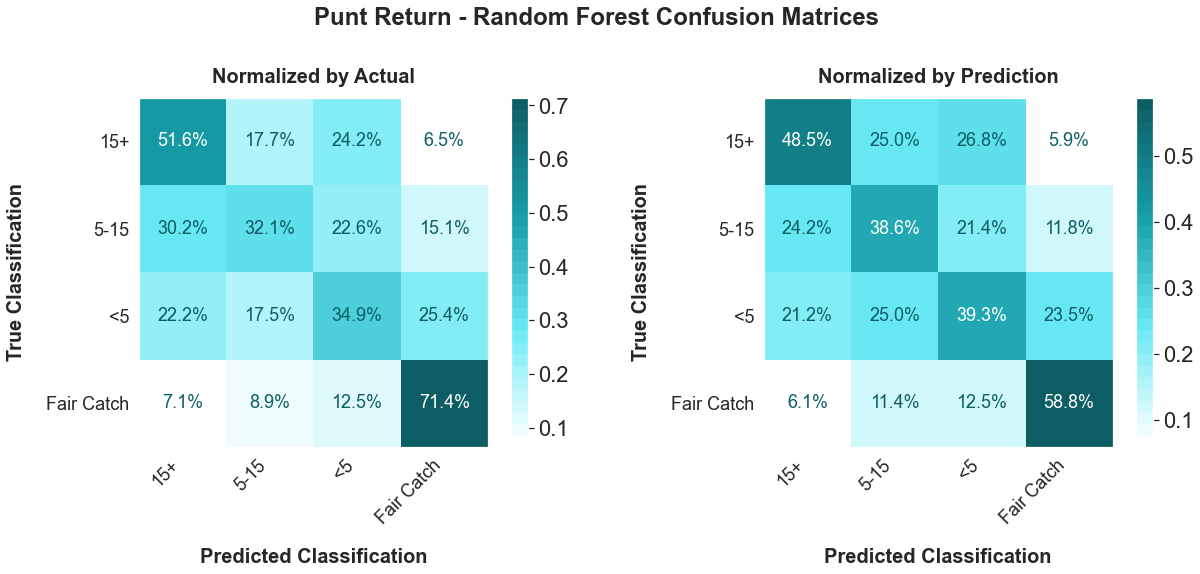

In [216]:
# Display confusion matrices
sns.set(font_scale=2.0)
plt.rcParams.update({'font.size': 18})

confusion(classifier=best_rf_classifier, x_test=x_test, y_test=y_test, y_pred=y_pred, model='Punt Return - Random Forest', cmap=cm)

## Coverage Throughout the Return

In [70]:
# Determine plays where the punt was received and returned, exclude muffed punts, fair catches, and penalty plays
punt_received = punt_tracking[(punt_tracking['event']=='punt_received')][['gameId', 'playId']]
punt_received = punt_received.merge(plays[['gameId', 'playId', 'specialTeamsResult', 'possessionTeam', 'penaltyJerseyNumbers']], on=['gameId', 'playId'])

punt_received['penaltyTeam'] = np.where(punt_received.apply(lambda x: str(x['possessionTeam']) in str(x['penaltyJerseyNumbers']), axis=1),
                                        np.where(punt_received.apply(lambda x: ';' in str(x["penaltyJerseyNumbers"]), axis=1), 'Both', 'Kicking'),
                                        np.where(punt_received['penaltyJerseyNumbers'].astype(str)=='nan', 'None', 'Receiving')
                                       )

punt_returned = punt_received[(~(punt_received['specialTeamsResult'].isin(['Muffed', 'Fair Catch']))) &
                              (~(punt_received['penaltyTeam'].isin(['Both', 'Receiving'])))
                             ]

In [71]:
# Create columns displaying the frameVsSnap for start and end of the return
starting_cols = ['gameId', 'playId', 'specialTeamsResult', 'possessionTeam', 'penaltyJerseyNumbers', 'penaltyTeam'] 
merge_cols = ['gameId', 'playId', 'frameVsSnap']

punt_returned = punt_returned.merge(punt_tracking[punt_tracking['event']=='punt_received'][merge_cols],
                                    on=['gameId', 'playId'], how='left')

punt_returned = punt_returned.merge(punt_tracking[punt_tracking['event']=='out_of_bounds'][merge_cols],
                                    on=['gameId', 'playId'], how='left', suffixes=('_rec', '_oob'))

punt_returned = punt_returned.merge(punt_tracking[punt_tracking['event']=='tackle'][merge_cols],
                                    on=['gameId', 'playId'], how='left', suffixes=('_oob', '_tackle'))

punt_returned = punt_returned.merge(punt_tracking[punt_tracking['event']=='touchdown'][merge_cols],
                                    on=['gameId', 'playId'], how='left', suffixes=('_tackle', '_td'))

punt_returned = punt_returned.merge(punt_tracking[punt_tracking['event']=='fumble'][merge_cols],
                                    on=['gameId', 'playId'], how='left', suffixes=('_td', '_fumble'))


punt_returned.columns = starting_cols + ['returnStart', 'outOfBounds', 'tackle', 'touchdown', 'fumble']

punt_returned = punt_returned.drop_duplicates()

punt_returned['returnEnd'] = punt_returned[['outOfBounds','tackle', 'touchdown']].min(axis=1)
punt_returned.dropna(subset=['returnEnd'], inplace=True)

In [72]:
# Exclude all plays with fumbles
punt_returned = punt_returned[punt_returned['fumble'].astype(str)=='nan']

In [73]:
# Calculate the distance between each defender and the football, as well as average and minimum by frame
football_position = punt_tracking[punt_tracking['rolePlayer']=='football'][['gameId', 'playId', 'frameVsSnap', 'x', 'y']]
football_position.columns = ['gameId', 'playId', 'frameVsSnap', 'x_football', 'y_football']

punt_tracking = punt_tracking.merge(football_position, on=['gameId', 'playId', 'frameVsSnap'])

punt_tracking['dist_to_football'] = np.sqrt((punt_tracking['x_football'] - punt_tracking['x'])**2 + (punt_tracking['y_football'] - punt_tracking['y'])**2)

dist_to_football = punt_tracking[(punt_tracking['kickingTeam'])].groupby(['gameId', 'playId', 'frameVsSnap'])['dist_to_football']\
                                                                .agg({np.min,np.mean})\
                                                                .reset_index()

dist_to_football.columns = ['gameId', 'playId', 'frameVsSnap', 'minDist_football', 'meanDist_football']

In [74]:
# Filter tracking data to show frames that occurred during the return
punt_tracking_during_return = punt_tracking.merge(punt_returned[['gameId', 'playId', 'returnStart', 'returnEnd']], on=['gameId', 'playId'])

punt_tracking_during_return.dropna(subset=['returnStart', 'returnEnd'], inplace=True)

punt_tracking_during_return = punt_tracking_during_return[(punt_tracking_during_return['frameVsSnap']>=punt_tracking_during_return['returnStart']) &
                                                          (punt_tracking_during_return['frameVsSnap']<=punt_tracking_during_return['returnEnd'])
                                                         ]

In [75]:
# Calculate whether each defender was within two yards of the football during the return
punt_tracking_during_return['defender_within_two_yds'] = np.where((punt_tracking_during_return['dist_to_football'] <= 2.0) &
                                                                  (punt_tracking_during_return['kickingTeam']) &
                                                                  (punt_tracking_during_return['rolePlayer']!='football'), 1, 0)

In [76]:
# Show punt return touchdowns sorted by number of defenders within two yards throughout the play
close_defenders = punt_tracking_during_return.groupby(['gameId', 'playId'])['defender_within_two_yds'].sum().reset_index().sort_values('defender_within_two_yds', ascending=False)

In [77]:
# Determine the length of the return in frames (time)
punt_tracking_during_return['returnTime'] = punt_tracking_during_return['returnEnd'] - punt_tracking_during_return['returnStart']

In [80]:
# Calculate movement of the football during the return
return_length = punt_tracking_during_return[['gameId', 'playId', 'frameVsSnap', 'x_football', 'y_football']].drop_duplicates()

return_length['x_change'] = return_length['x_football'].diff()
return_length['y_change'] = return_length['y_football'].diff()
return_length['football_movement'] = np.sqrt(return_length['x_change']**2 + return_length['y_change']**2)


mask = ((return_length['gameId']==return_length['gameId'].shift(1)) &
        (return_length['playId']==return_length['playId'].shift(1))
       )

return_length['football_movement'] = np.where(mask!=True, np.nan, return_length['football_movement'])

return_length = return_length.groupby(['gameId', 'playId'])['football_movement'].sum().reset_index()

In [84]:
# Merge tables to create return difficulty table
return_difficulty = return_length.merge(close_defenders, on=['gameId', 'playId'], how='left')

return_difficulty = return_difficulty.merge(punt_tracking_during_return[['gameId', 'playId', 'returnTime']].drop_duplicates(),
                                            on=['gameId', 'playId'], how='left'
                                           )

In [84]:
# Add broken tackles to the return difficulty table
pff['brokenTackles'] = pff['missedTackler'].str.count(';') + 1

return_difficulty = return_difficulty.merge(pff[['gameId', 'playId', 'brokenTackles']],
                                            on=['gameId', 'playId'], how='left'
                                           )

return_difficulty['brokenTackles'].fillna(0, inplace=True)

In [88]:
# Convert return difficulty metrics to percentile ranking and calculate the average of all metrics
return_difficulty_perc = return_difficulty.copy()

for col in ['football_movement', 'defender_within_two_yds', 'returnTime', 'brokenTackles']:
    return_difficulty_perc[col] = return_difficulty_perc[col].rank(pct=True)

return_difficulty_perc['difficulty'] = 0.25 * (return_difficulty_perc['football_movement'] +
                                               return_difficulty_perc['defender_within_two_yds'] +
                                               return_difficulty_perc['returnTime'] +
                                               return_difficulty_perc['brokenTackles']
                                              )

In [94]:
# Merge game and player identification information to the return difficulty table for presentation
return_difficulty_perc = return_difficulty_perc.merge(games[['gameId', 'season', 'week', 'homeTeamAbbr', 'visitorTeamAbbr']],
                                                      on=['gameId'])

return_difficulty_perc = return_difficulty_perc.merge(punt_tracking[['gameId', 'playId', 'possessionTeam', 'returnerId']].drop_duplicates(),
                                                      on=['gameId', 'playId'])

return_difficulty_perc = return_difficulty_perc.merge(players[['nflId', 'displayName']], left_on=['returnerId'], right_on=['nflId'])

return_difficulty_perc['returnTeam'] = np.where(return_difficulty_perc['possessionTeam']==return_difficulty_perc['homeTeamAbbr'],
                                                return_difficulty_perc['visitorTeamAbbr'],
                                                return_difficulty_perc['homeTeamAbbr']
                                               )

return_difficulty_perc = return_difficulty_perc.merge(punt_returned[['gameId', 'playId', 'touchdown']], on=['gameId', 'playId'])

# Add touchdown column (yes/no) 
return_difficulty_perc['touchdown'] = np.where(return_difficulty_perc['touchdown'] > 0, 'Yes', 'No')

In [94]:
# Prepare return difficulty table for presentation
presentation_order = ['season', 'week', 'homeTeamAbbr', 'visitorTeamAbbr', 'possessionTeam', 'returnTeam',
                      'displayName', 'touchdown', 'difficulty', 'defender_within_two_yds', 'football_movement', 
                      'returnTime', 'brokenTackles']

new_names = ['Season', 'Week', 'Home', 'Away', 'Kick Team', 'Return Team', 'Returner', 'Touchdown', 'Difficulty', 'Defender Proximity',
             'Total Movement', 'Return Time', 'Broken Tackles']

return_difficulty_presentation = return_difficulty_perc[presentation_order]

return_difficulty_presentation.columns = new_names

### Punt Return Touchdowns - Degree of Difficulty

In [243]:
# Display punt return TD's sorted by difficulty
cm = sns.color_palette('RdYlGn', as_cmap=True)
heatmap_cols = ['Difficulty', 'Defender Proximity', 'Total Movement', 'Return Time', 'Broken Tackles']

return_difficulty_presentation[return_difficulty_presentation['Touchdown']=='Yes'].sort_values('Difficulty', ascending=False)\
                                                                                  .style.hide_index()\
                                                                                  .background_gradient(cmap=cm, subset=heatmap_cols)


Season,Week,Home,Away,Kick Team,Return Team,Returner,Touchdown,Difficulty,Defender Proximity,Total Movement,Return Time,Broken Tackles
2018,1,DET,NYJ,DET,NYJ,Andre Roberts,Yes,0.928910,0.767246,0.998420,0.994734,0.955240
2020,17,BUF,MIA,MIA,BUF,Isaiah McKenzie,Yes,0.887309,0.597683,0.996840,0.999473,0.955240
2019,16,DEN,DET,DEN,DET,Jamal Agnew,Yes,0.863152,0.515271,0.989995,0.992101,0.955240
2019,16,IND,CAR,CAR,IND,Nyheim Hines,Yes,0.858083,0.492364,0.990521,0.994207,0.955240
2020,8,MIA,LA,LA,MIA,Jakeem Grant,Yes,0.848407,0.443128,0.998947,0.996314,0.955240
2018,5,CIN,MIA,CIN,MIA,Jakeem Grant,Yes,0.846432,0.443128,0.995261,0.992101,0.955240
2018,16,OAK,DEN,DEN,OAK,Dwayne Harris,Yes,0.828923,0.515271,1.000000,1.000000,0.800421
2020,13,LAC,NE,LAC,NE,Gunner Olszewski,Yes,0.816417,0.492364,0.987362,0.985519,0.800421
2019,16,IND,CAR,CAR,IND,Nyheim Hines,Yes,0.813454,0.467088,0.993154,0.993154,0.800421
2019,5,LAC,DEN,DEN,LAC,Desmond King,Yes,0.799368,0.413902,0.991048,0.992101,0.800421


### All Punt Returns - Degree of Difficulty

In [244]:
return_difficulty_presentation.sort_values('Difficulty', ascending=False)\
                              .style.hide_index()\
                              .background_gradient(cmap=cm, subset=heatmap_cols)


## Gunner Penetration and Vise Protection

#### Filter for Punt Plays of 40+ Yards with No Penalties

In [96]:
# Determine list of plays that meet criteria:  no penalties, 40+ yard punt
punt_play_subset = plays.copy()
punt_play_subset['penaltyCodes'] = punt_play_subset['penaltyCodes'].astype(str)

punt_play_subset = punt_play_subset[(punt_play_subset['kickLength'] >= 40) &
                                    (punt_play_subset['penaltyCodes'] == 'nan')]

# Filter gunner and vise tracking data for punt plays meeting the above criteria
punt_play_subset['game_play'] = punt_play_subset['gameId'].astype(str) + '-' + punt_play_subset['playId'].astype(str)
gunners_and_vises_tracking = punt_tracking[punt_tracking['rolePlayer'].isin(['gunner', 'vise'])].copy()
gunners_and_vises_tracking['game_play'] = gunners_and_vises_tracking['gameId'].astype(str) + '-' + gunners_and_vises_tracking['playId'].astype(str)

gunners_and_vises_tracking = gunners_and_vises_tracking[gunners_and_vises_tracking['game_play'].isin(punt_play_subset['game_play'])]

#### Match Each Gunner with a Vise and Combine Their Tracking Data to One Row Per Frame

In [97]:
# Filter for gunner and vise positions at the snap
gunners_and_vises_at_snap = gunners_and_vises_tracking[gunners_and_vises_tracking['frameVsSnap']==0].copy()

# Count number of gunners and vises per play and only keep plays with even numbers of gunners and vises (one on one)
gunner_vise_count = gunners_and_vises_at_snap.groupby(['gameId', 'playId', 'rolePlayer']).size().unstack(fill_value=0).reset_index()
one_on_one_punts = gunner_vise_count[gunner_vise_count['gunner']==gunner_vise_count['vise']]

one_on_one_at_snap = gunners_and_vises_at_snap.merge(one_on_one_punts, 
                                                     on=['gameId', 'playId'],
                                                     how='right')[['gameId', 'playId', 'nflId', 'rolePlayer', 'x', 'y']]

In [98]:
# Separate gunners and vises and then concatenate horizontally, matching each gunner with the vise lined up against him
gunners_at_snap = one_on_one_at_snap[one_on_one_at_snap['rolePlayer']=='gunner'].sort_values(['gameId', 'playId', 'y']).reset_index(drop=True)
vises_at_snap = one_on_one_at_snap[one_on_one_at_snap['rolePlayer']=='vise'].sort_values(['gameId', 'playId', 'y']).reset_index(drop=True)

gunners_vs_vises = pd.concat([gunners_at_snap[['gameId', 'playId', 'nflId']], vises_at_snap[['nflId']]], axis=1).reset_index(drop=True)

gunners_vs_vises.columns = ['gameId', 'playId', 'gunnerId', 'viseId']

In [99]:
# Separate tracking data for gunners and vises and concatenate horizonally, matching each gunner with the vise lined up against him
gunner_tracking = gunners_and_vises_tracking[gunners_and_vises_tracking['rolePlayer']=='gunner'][['gameId', 'playId', 'nflId', 'frameVsSnap', 'x', 'y']]
vise_tracking = gunners_and_vises_tracking[gunners_and_vises_tracking['rolePlayer']=='vise'][['gameId', 'playId', 'nflId', 'frameVsSnap', 'x', 'y']]

gunner_cols = ['gameId', 'playId', 'gunnerId', 'frameVsSnap', 'x_gunner', 'y_gunner']
vise_cols = ['gameId', 'playId', 'viseId', 'frameVsSnap', 'x_vise', 'y_vise']

gunner_tracking.columns = gunner_cols
vise_tracking.columns = vise_cols

gunner_vs_vise_tracking = gunner_tracking.merge(gunners_vs_vises, on=['gameId', 'playId', 'gunnerId'])

gunner_vs_vise_tracking = gunner_vs_vise_tracking.merge(vise_tracking, on=['gameId', 'playId', 'frameVsSnap', 'viseId'])

In [100]:
# Display the resulting dataframe, showing gunner and matching vise tracking data by frame
gunner_vs_vise_tracking.head()

,gameId,playId,gunnerId,frameVsSnap,x_gunner,y_gunner,viseId,x_vise,y_vise
0,2018123000,892,43407.0,-10,38.13,4.593333,43498.0,39.97,5.373333
1,2018123000,892,43407.0,-9,38.13,4.593333,43498.0,39.97,5.373333
2,2018123000,892,43407.0,-8,38.13,4.593333,43498.0,39.97,5.373333
3,2018123000,892,43407.0,-7,38.13,4.593333,43498.0,39.98,5.373333
4,2018123000,892,43407.0,-6,38.13,4.593333,43498.0,39.98,5.373333


#### Calculate Gunner Penetration by Frame (Absolute and Relative to Vise Position)

In [101]:
# Determine gunner and vise positions at the snap and add to tracking data
positions_at_snap = gunner_vs_vise_tracking[gunner_vs_vise_tracking['frameVsSnap']==0]
positions_at_snap.columns = ['gameId', 'playId', 'gunnerId', 'frameVsSnap', 'x_gunner_snap', 'y_gunner_snap',
                             'viseId', 'x_vise_snap', 'y_vise_snap']

gunner_vs_vise_tracking = gunner_vs_vise_tracking.merge(positions_at_snap[['gameId', 'playId', 'gunnerId', 'x_gunner_snap', 
                                                                           'y_gunner_snap', 'x_vise_snap', 'y_vise_snap']],
                                                        on=['gameId', 'playId', 'gunnerId'])

In [102]:
# Calculate gunner penetration (yards downfield) in absolute terms and verus the vise position
gunner_vs_vise_tracking['gunner_penetration'] = gunner_vs_vise_tracking['x_gunner'] - gunner_vs_vise_tracking['x_gunner_snap']
gunner_vs_vise_tracking['gunner_penetration_vs_vise'] = gunner_vs_vise_tracking['x_gunner'] - gunner_vs_vise_tracking['x_vise']

In [103]:
# Display the resulting dataframe, showing gunner and matching vise tracking data by frame
gunner_vs_vise_tracking.head()

,gameId,playId,gunnerId,frameVsSnap,x_gunner,y_gunner,viseId,x_vise,y_vise,x_gunner_snap,y_gunner_snap,x_vise_snap,y_vise_snap,gunner_penetration,gunner_penetration_vs_vise
0,2018123000,892,43407.0,-10,38.13,4.593333,43498.0,39.97,5.373333,38.14,4.583333,39.97,5.363333,-0.01,-1.84
1,2018123000,892,43407.0,-9,38.13,4.593333,43498.0,39.97,5.373333,38.14,4.583333,39.97,5.363333,-0.01,-1.84
2,2018123000,892,43407.0,-8,38.13,4.593333,43498.0,39.97,5.373333,38.14,4.583333,39.97,5.363333,-0.01,-1.84
3,2018123000,892,43407.0,-7,38.13,4.593333,43498.0,39.98,5.373333,38.14,4.583333,39.97,5.363333,-0.01,-1.85
4,2018123000,892,43407.0,-6,38.13,4.593333,43498.0,39.98,5.373333,38.14,4.583333,39.97,5.363333,-0.01,-1.85


#### Rank Gunners and Vises by Penetration Metrics

In [104]:
def top_gunner_vise(df, players, metric, frame, cutoff, id_field, ascend=False):
    """
    Return df with top gunners/vises for given metric and frame of play. Only return if number of punts cutoff is met.
    """
    
    # Calculate average of metric for given frame
    best_by_frame = df[df['frameVsSnap']==frame].groupby(id_field)[[metric]]\
                                                .mean()\
                                                .reset_index()\
                                                .sort_values(metric, ascending=ascend)
    
    # Determine number of qualifying punt plays for each gunner/vise
    punt_count = df[df['frameVsSnap']==frame].groupby(id_field)[[metric]].count().reset_index().sort_values(metric, ascending=ascend)

    # Merge punt play count to average by player and exclude players who do not meet the cutoff
    best_by_frame = best_by_frame.merge(punt_count, on=id_field).sort_values(metric + '_y', ascending=ascend)\
                                 .merge(players[['nflId', 'displayName']], left_on=id_field, right_on='nflId').drop(columns='nflId')
    
    best_by_frame.columns = [id_field, 'avg_' + metric, 'punt_plays', 'name']
    
    best_by_frame = best_by_frame[best_by_frame['punt_plays']>cutoff][['name', id_field, 'avg_' + metric, 'punt_plays']]\
                        .sort_values('avg_' + metric, ascending=ascend)
    
    # Add ranking column and return dataframe with ranking
    best_by_frame['rank'] = best_by_frame['avg_' + metric].rank(ascending=ascend).astype(int)
    
    return best_by_frame[['rank', id_field, 'name', 'avg_' + metric, 'punt_plays']].reset_index(drop=True)

In [105]:
# Establish number of punt plays required to be ranked
cutoff = 15

In [106]:
# Calculate absolute and relative penetration for gunners 3, 4, and 5 seconds into the play
gunner_penetration_frame30 = top_gunner_vise(df=gunner_vs_vise_tracking, 
                                             players=players,
                                             metric='gunner_penetration', 
                                             frame=30, 
                                             cutoff=cutoff,
                                             id_field='gunnerId',
                                             ascend=False)

gunner_penetration_frame40 = top_gunner_vise(df=gunner_vs_vise_tracking, 
                                             players=players,
                                             metric='gunner_penetration', 
                                             frame=40, 
                                             cutoff=cutoff,
                                             id_field='gunnerId',
                                             ascend=False)

gunner_penetration_frame50 = top_gunner_vise(df=gunner_vs_vise_tracking, 
                                             players=players,
                                             metric='gunner_penetration', 
                                             frame=50, 
                                             cutoff=cutoff,
                                             id_field='gunnerId',
                                             ascend=False)

gunner_penetration_vs_vise_frame30 = top_gunner_vise(df=gunner_vs_vise_tracking, 
                                                     players=players,
                                                     metric='gunner_penetration_vs_vise', 
                                                     frame=30, 
                                                     cutoff=cutoff,
                                                     id_field='gunnerId',
                                                     ascend=False)

gunner_penetration_vs_vise_frame40 = top_gunner_vise(df=gunner_vs_vise_tracking, 
                                                     players=players,
                                                     metric='gunner_penetration_vs_vise', 
                                                     frame=40, 
                                                     cutoff=cutoff,
                                                     id_field='gunnerId',
                                                     ascend=False)

gunner_penetration_vs_vise_frame50 = top_gunner_vise(df=gunner_vs_vise_tracking, 
                                                     players=players,
                                                     metric='gunner_penetration_vs_vise', 
                                                     frame=50, 
                                                     cutoff=cutoff,
                                                     id_field='gunnerId',
                                                     ascend=False)

In [107]:
# Merge gunner rankings into a single dataframe and organize for presentation
original_cols = ['gunnerId', 'name', 'punt_plays', 'rank']
merge_cols = ['gunnerId', 'rank']

gunner_merged = gunner_penetration_frame30[original_cols].merge(gunner_penetration_frame40[merge_cols], on='gunnerId')

gunner_merged = gunner_merged.merge(gunner_penetration_frame50[merge_cols], on='gunnerId')

gunner_merged = gunner_merged.merge(gunner_penetration_vs_vise_frame30[merge_cols], on='gunnerId')

gunner_merged = gunner_merged.merge(gunner_penetration_vs_vise_frame40[merge_cols], on='gunnerId')

gunner_merged = gunner_merged.merge(gunner_penetration_vs_vise_frame50[merge_cols], on='gunnerId')

gunner_merged.columns = ['gunnerId', 'Name', 'Punt Plays', 'Penetration (3 Sec)', 'Penetration (4 Sec)', 'Penetration (5 Sec)',
                         'Vs Vise (3 Sec)', 'Vs Vise (4 Sec)', 'Vs Vise (5 Sec)']

In [108]:
# Calculate absolute and relative penetration vs vises 3, 4, and 5 seconds into the play
vise_penetration_frame30 = top_gunner_vise(df=gunner_vs_vise_tracking, 
                                           players=players,
                                           metric='gunner_penetration', 
                                           frame=30, 
                                           cutoff=cutoff,
                                           id_field='viseId',
                                           ascend=True)

vise_penetration_frame40 = top_gunner_vise(df=gunner_vs_vise_tracking, 
                                           players=players,
                                           metric='gunner_penetration', 
                                           frame=40, 
                                           cutoff=cutoff,
                                           id_field='viseId',
                                           ascend=True)

vise_penetration_frame50 = top_gunner_vise(df=gunner_vs_vise_tracking, 
                                           players=players,
                                           metric='gunner_penetration', 
                                           frame=50, 
                                           cutoff=cutoff,
                                           id_field='viseId',
                                           ascend=True)

vise_penetration_vs_vise_frame30 = top_gunner_vise(df=gunner_vs_vise_tracking, 
                                                   players=players,
                                                   metric='gunner_penetration_vs_vise', 
                                                   frame=30, 
                                                   cutoff=cutoff,
                                                   id_field='viseId',
                                                   ascend=True)

vise_penetration_vs_vise_frame40 = top_gunner_vise(df=gunner_vs_vise_tracking, 
                                                   players=players,
                                                   metric='gunner_penetration_vs_vise', 
                                                   frame=40, 
                                                   cutoff=cutoff,
                                                   id_field='viseId',
                                                   ascend=True)

vise_penetration_vs_vise_frame50 = top_gunner_vise(df=gunner_vs_vise_tracking, 
                                                   players=players,
                                                   metric='gunner_penetration_vs_vise', 
                                                   frame=50, 
                                                   cutoff=cutoff,
                                                   id_field='viseId',
                                                   ascend=True)

In [110]:
# Merge gunner rankings into a single dataframe and organize for presentation
original_cols = ['viseId', 'name', 'punt_plays', 'rank']
merge_cols = ['viseId', 'rank']

vise_merged = vise_penetration_frame30[original_cols].merge(vise_penetration_frame40[merge_cols], on='viseId')

vise_merged = vise_merged.merge(vise_penetration_frame50[merge_cols], on='viseId')

vise_merged = vise_merged.merge(vise_penetration_vs_vise_frame30[merge_cols], on='viseId')

vise_merged = vise_merged.merge(vise_penetration_vs_vise_frame40[merge_cols], on='viseId')

vise_merged = vise_merged.merge(vise_penetration_vs_vise_frame50[merge_cols], on='viseId')

vise_merged.columns = ['viseId', 'Name', 'Punt Plays', 'Penetration (3 Sec)', 'Penetration (4 Sec)', 'Penetration (5 Sec)',
                         'Vs Vise (3 Sec)', 'Vs Vise (4 Sec)', 'Vs Vise (5 Sec)']

#### Gunner Rankings

In [111]:
# Add "Average Rank" column, sort, add heatmap, and present
gunner_merged['Average Rank'] = gunner_merged[['Penetration (3 Sec)', 'Penetration (4 Sec)', 'Penetration (5 Sec)',
                                               'Vs Vise (3 Sec)', 'Vs Vise (4 Sec)', 'Vs Vise (5 Sec)']].mean(axis=1)

cm = sns.color_palette('RdYlGn_r', as_cmap=True)

no_heatmap_cols = ['Name', 'Punt Plays']
heatmap_cols = ['Average Rank', 'Penetration (3 Sec)', 'Penetration (4 Sec)', 'Penetration (5 Sec)',
                'Vs Vise (3 Sec)', 'Vs Vise (4 Sec)', 'Vs Vise (5 Sec)']

gunner_merged.sort_values('Average Rank')[no_heatmap_cols + heatmap_cols].style.hide_index()\
                                                                               .background_gradient(cmap=cm,subset=heatmap_cols)

Name,Punt Plays,Average Rank,Penetration (3 Sec),Penetration (4 Sec),Penetration (5 Sec),Vs Vise (3 Sec),Vs Vise (4 Sec),Vs Vise (5 Sec)
Johnny Holton,22,4.833333,1,6,11,4,2,5
Rudy Ford,31,5.000000,5,1,2,7,5,10
Brandon Williams,25,5.333333,2,2,3,8,6,11
Dane Cruikshank,28,6.333333,11,10,9,1,3,4
Chris Milton,34,7.500000,6,4,5,9,9,12
Brandon Wilson,26,8.666667,10,9,6,13,8,6
Mike Thomas,22,10.333333,3,8,7,15,13,16
Justin Hardee,39,12.166667,9,3,1,25,20,15
Antonio Hamilton,28,12.666667,12,12,13,5,11,23
Matt Slater,30,13.166667,4,5,8,20,22,20


#### Vise Rankings

In [112]:
# Add "Average Rank" column, sort, add heatmap, and present
vise_merged['Average Rank'] = vise_merged[['Penetration (3 Sec)', 'Penetration (4 Sec)', 'Penetration (5 Sec)',
                                             'Vs Vise (3 Sec)', 'Vs Vise (4 Sec)', 'Vs Vise (5 Sec)']].mean(axis=1)

vise_merged.sort_values('Average Rank')[no_heatmap_cols + heatmap_cols].style.hide_index()\
                                                                             .background_gradient(cmap=cm,subset=heatmap_cols)

Name,Punt Plays,Average Rank,Penetration (3 Sec),Penetration (4 Sec),Penetration (5 Sec),Vs Vise (3 Sec),Vs Vise (4 Sec),Vs Vise (5 Sec)
Tavierre Thomas,26,3.166667,5,4,3,4,1,2
Tarvarius Moore,20,5.000000,2,1,1,16,5,5
Jamal Perry,29,5.833333,8,6,5,10,3,3
Justin Layne,29,6.166667,4,3,4,9,8,9
Holton Hill,22,7.500000,10,5,2,14,7,7
Justin Coleman,21,11.666667,6,8,7,24,12,13
Jamel Dean,16,14.166667,1,2,6,20,20,36
Brandon Facyson,37,15.000000,3,7,9,29,24,18
Tye Smith,19,17.833333,19,14,13,6,6,49
Marvell Tell,17,18.333333,24,24,22,23,13,4
